# Задание 2

**Выполнил**: Подцепко Игорь, M4138

1. Используя код практики или PyTorch, реализовать 3 оптимизатора (например, Nesterov, Adam, RMSProp).
2. Реализовать любые 2 шедулера (например, StepLR и ExponentialLR). Проверить реализованное на сгенерированной регрессии.
3. Показать графики изменения LR в течение 100 эпох.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from typing import Iterable, List, Tuple
from tqdm import tqdm

## 1. Реализация оптимизаторов

Во-первых, реализуем простые тестовые модели, на которых можно будет сравнивать написанные реализации оптимизаторов с аналогичными из PyTorch

In [2]:
f1 = torch.nn.Linear(in_features=10, out_features=10)
f2 = torch.nn.Linear(in_features=10, out_features=10)

Для сравнения тензоров будем использовать функцию `torch.allclose`, которая выполняет сравнение с заданной точностью.

In [3]:
def assert_eq(t1: torch.Tensor, t2: torch.Tensor):
    assert torch.allclose(t1, t2, rtol=1e-5, atol=1e-7)

При сравнении реализаций критерием корректности будет являться совпадение весов на протяжении некоторого числа эпох (по умолчанию — 10000).

In [4]:
def assert_optimizers_eq(
    o1: torch.optim.Optimizer, o2: torch.optim.Optimizer, n: int = 10000
):
    f2.weight.data = f1.weight.data.clone()
    f2.bias.data = f1.bias.data.clone()
    c = torch.nn.MSELoss()

    for _ in tqdm(range(n)):
        x = torch.randn(10, requires_grad=True)

        y1 = f1(x)
        l1 = c(y1, x**2 - 2 * x + 1)
        l1.backward()
        o1.step()
        o1.zero_grad()

        y2 = f2(x)
        l2 = c(y2, x**2 - 2 * x + 1)
        l2.backward()
        o2.step()
        o2.zero_grad()

        assert_eq(f1.weight.data, f2.weight.data)
        assert_eq(f1.bias.data, f2.bias.data)

### Реализация Nesterov

In [5]:
class Nesterov(torch.optim.Optimizer):
    def __init__(
        self, params: Iterable[torch.Tensor], lr: float = 0.01, momentum: float = 0.9
    ):
        defaults = dict(lr=lr, momentum=momentum)
        super(Nesterov, self).__init__(params, defaults)

    @torch.no_grad()
    def step(self):
        for group in self.param_groups:
            lr = group["lr"]
            momentum = group["momentum"]

            for param in group["params"]:
                g = param.grad

                state = self.state[param]
                if "u" not in state:
                    u = state["u"] = g.clone()
                else:
                    u = state["u"]
                    # Накапливаем градиент с затуханием:
                    u.mul_(momentum).add_(g)

                # Делаем шаг с опрежением:
                param.sub_(g + momentum * u, alpha=lr)


o1 = torch.optim.SGD(f1.parameters(), lr=1e-3, momentum=0.9, nesterov=True)
o2 = Nesterov(f2.parameters(), lr=1e-3, momentum=0.9)

assert_optimizers_eq(o1, o2)

100%|██████████| 10000/10000 [00:03<00:00, 2815.26it/s]


## Реализация RMSprop

In [6]:
class RMSprop(torch.optim.Optimizer):
    def __init__(
        self,
        params: Iterable[torch.Tensor],
        lr: float = 0.01,
        alpha: float = 0.99,
        eps: float = 1e-8,
    ):
        defaults = dict(lr=lr, alpha=alpha, eps=eps)
        super(RMSprop, self).__init__(params, defaults)

    @torch.no_grad()
    def step(self):
        for group in self.param_groups:
            lr = group["lr"]
            alpha = group["alpha"]
            eps = group["eps"]

            for param in group["params"]:
                g = param.grad

                state = self.state[param]
                if "v" not in state:
                    state["v"] = torch.zeros_like(param)

                v = state["v"]
                v.mul_(alpha).add_((1 - alpha) * g**2)

                param.addcdiv_(g, torch.sqrt(v) + eps, value=-lr)


o1 = torch.optim.RMSprop(f1.parameters(), lr=0.01, alpha=0.99)
o2 = RMSprop(f2.parameters(), lr=0.01, alpha=0.99)

assert_optimizers_eq(o1, o2)

100%|██████████| 10000/10000 [00:03<00:00, 2608.62it/s]


### Реализация Adam

In [7]:
class Adam(torch.optim.Optimizer):
    def __init__(
        self,
        params: Iterable[torch.Tensor],
        lr: float = 0.001,
        betas: Tuple[float, float] = (0.9, 0.999),
        eps: float = 1e-08,
    ):
        defaults = dict(lr=lr, betas=betas, eps=eps)
        super(Adam, self).__init__(params, defaults)

    @torch.no_grad()
    def step(self):
        for group in self.param_groups:
            lr = group["lr"]
            beta_1, beta_2 = group["betas"]
            eps = group["eps"]

            for param in group["params"]:
                g = param.grad

                state = self.state[param]
                if "epoch" not in state:
                    state["epoch"] = 0
                    state["first_moment"] = torch.zeros_like(param)
                    state["second_moment"] = torch.zeros_like(param)

                t = state["epoch"] = state["epoch"] + 1
                m = state["first_moment"]
                v = state["second_moment"]

                m.mul_(beta_1).add_(g, alpha=(1 - beta_1))
                v.mul_(beta_2).add_(g**2, alpha=(1 - beta_2))

                m_hat = m / (1 - beta_1**t)
                v_hat = v / (1 - beta_2**t)

                param.addcdiv_(m_hat, torch.sqrt(v_hat) + eps, value=-lr)


o1 = torch.optim.Adam(f1.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)
o2 = Adam(f2.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)

assert_optimizers_eq(o1, o2)

100%|██████████| 10000/10000 [00:04<00:00, 2441.44it/s]


## 2. Реализация шедулеров

In [8]:
def check_scheduler(
    expected_lrs: List[float], initial_lr: float, scheduler_ctor, *args, **kwargs
):
    o = torch.optim.SGD(f1.parameters(), lr=initial_lr)
    s: torch.optim.lr_scheduler.LRScheduler = scheduler_ctor(o, *args, **kwargs)
    actual_lrs = []
    for _ in range(len(expected_lrs)):
        actual_lrs.append(s.get_last_lr()[0])
        o.step()
        s.step()
    assert_eq(torch.Tensor(expected_lrs), torch.Tensor(actual_lrs))

In [9]:
class LinearLR(torch.optim.lr_scheduler.LRScheduler):
    def __init__(
        self,
        optimizer: torch.optim.Optimizer,
        start_factor: float = 0.3333333333333333,
        end_factor: float = 1.0,
        total_iters: int = 5,
        last_epoch: int = -1,
        verbose: str = "deprecated",
    ):
        self.start_factor = start_factor
        self.total_iters = total_iters
        self.delta = (end_factor - start_factor) / total_iters
        super(LinearLR, self).__init__(optimizer, last_epoch, verbose)

    def get_lr(self) -> list[float]:
        factor: float = self._get_lr_factor()
        return [factor * group["initial_lr"] for group in self.optimizer.param_groups]

    def _get_lr_factor(self) -> float:
        return self.start_factor + min(self.last_epoch, self.total_iters) * self.delta


check_scheduler(
    [0.025, 0.03125, 0.0375, 0.04375, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05],
    initial_lr=0.05,
    scheduler_ctor=LinearLR,
    start_factor=0.5,
    total_iters=4,
)

check_scheduler(
    [0.01, 0.009, 0.008, 0.007, 0.006, 0.005, 0.005, 0.005, 0.005, 0.005],
    initial_lr=0.01,
    scheduler_ctor=LinearLR,
    start_factor=1.0,
    end_factor=0.5,
    total_iters=5,
)

In [10]:
class StepLR(torch.optim.lr_scheduler.LRScheduler):
    def __init__(
        self,
        optimizer: torch.optim.Optimizer,
        step_size: int,
        gamma: float = 0.1,
        last_epoch: int = -1,
        verbose: str = "deprecated",
    ):
        self.step_size: int = step_size
        self.gamma: float = gamma
        super(StepLR, self).__init__(optimizer, last_epoch, verbose)

    def get_lr(self) -> list[float]:
        factor: float = self._get_lr_factor()
        return [factor * group["initial_lr"] for group in self.optimizer.param_groups]

    def _get_lr_factor(self) -> float:
        return self.gamma ** (self.last_epoch // self.step_size)


check_scheduler(
    [0.1, 0.1, 0.1, 0.01, 0.01, 0.01, 0.001, 0.001, 0.001],
    initial_lr=0.1,
    scheduler_ctor=StepLR,
    step_size=3,
    gamma=0.1,
)

## Проверка на сгенерированной регрессии

Воспользуемся примером с практики:

In [11]:
torch.manual_seed(1)

dataset_size = 500

X = torch.rand((dataset_size, 2)) * 4 - 2

y = X[:, 0] * X[:, 1] * 1.5
y = y.view(-1, 1)

In [12]:
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.network = torch.nn.Sequential(
            torch.nn.Linear(2, 100), torch.nn.ReLU(), torch.nn.Linear(100, 1)
        )

    def forward(self, x: torch.Tensor):
        return self.network(x)

In [13]:
def train_model(
    model: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    scheduler: torch.optim.lr_scheduler.LRScheduler | None = None,
    criterion: torch.nn.Module = torch.nn.MSELoss(),
    n_epochs: int = 100,
) -> Tuple[List[float], List[float]]:
    lrs = []
    losses = []

    model.train()
    for _ in range(n_epochs):
        y_pred = model(X)
        loss = criterion(y_pred, y)
        loss.backward()

        optimizer.step()
        if scheduler is not None:
            lrs.append(scheduler.get_last_lr()[0])
            scheduler.step()
        optimizer.zero_grad()

        losses.append(loss.item())

    if scheduler is None:
        return losses
    return losses, lrs

In [20]:
torch.manual_seed(2)

initial_lr = 5e-3

optimizers = {
    "Nesterov": lambda model: Nesterov(model.parameters(), lr=0.01, momentum=0.9),
    "RMSprop": lambda model: RMSprop(model.parameters(), lr=initial_lr, alpha=0.99),
    "Adam": lambda model: Adam(
        model.parameters(), lr=initial_lr, betas=(0.9, 0.999), eps=1e-08
    ),
}

schedulers = {
    "LinearLR": lambda optimizer: LinearLR(
        optimizer, start_factor=1.0, end_factor=0.5, total_iters=100
    ),
    "StepLR": lambda optimizer: StepLR(optimizer, step_size=30, gamma=0.1),
}


def create_model_optimizer_and_scheduler(optimizer_ctor, scheduler_ctor=None):
    model = Model()
    optimizer = optimizer_ctor(model)

    if scheduler_ctor is None:
        return model, optimizer

    scheduler = scheduler_ctor(optimizer)
    return model, optimizer, scheduler


n_epochs = 100
results = dict()

for optimizer_label, optimizer_ctor in optimizers.items():
    for scheduler_label, scheduler_ctor in schedulers.items():
        model, optimizer, scheduler = create_model_optimizer_and_scheduler(
            optimizer_ctor, scheduler_ctor
        )
        print(f"Обучение с оптимизатором {optimizer_label} и {scheduler_label}...")
        losses, lrs = train_model(model, optimizer, scheduler, n_epochs=n_epochs)
        results[f"{optimizer_label} + {scheduler_label}"] = (losses, lrs)
        print(f"Ошибка: {losses[-1]}")

    model, optimizer = create_model_optimizer_and_scheduler(optimizer_ctor)
    print(f"Обучение с оптимизатором {optimizer_label}...")
    losses = train_model(model, optimizer, n_epochs=n_epochs)
    results[optimizer_label] = losses
    print(f"Ошибка: {losses[-1]}")

Обучение с оптимизатором Nesterov и LinearLR...
Ошибка: 0.04609091579914093
Обучение с оптимизатором Nesterov и StepLR...
Ошибка: 0.07562489062547684
Обучение с оптимизатором Nesterov...
Ошибка: 0.04240177571773529
Обучение с оптимизатором RMSprop и LinearLR...
Ошибка: 0.03676296025514603
Обучение с оптимизатором RMSprop и StepLR...
Ошибка: 0.07197040319442749
Обучение с оптимизатором RMSprop...
Ошибка: 0.05599112808704376
Обучение с оптимизатором Adam и LinearLR...
Ошибка: 0.062390755861997604
Обучение с оптимизатором Adam и StepLR...
Ошибка: 0.12277521938085556
Обучение с оптимизатором Adam...
Ошибка: 0.043940238654613495


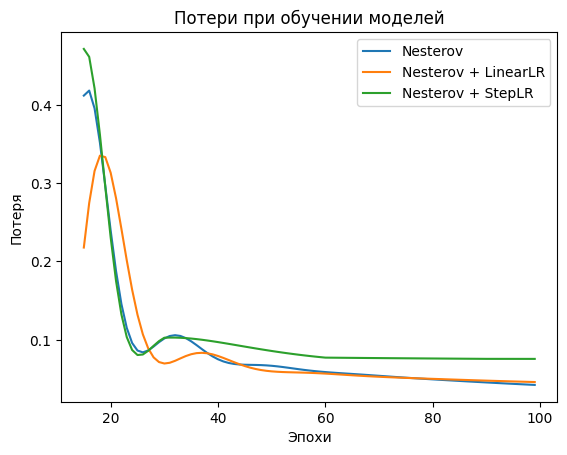

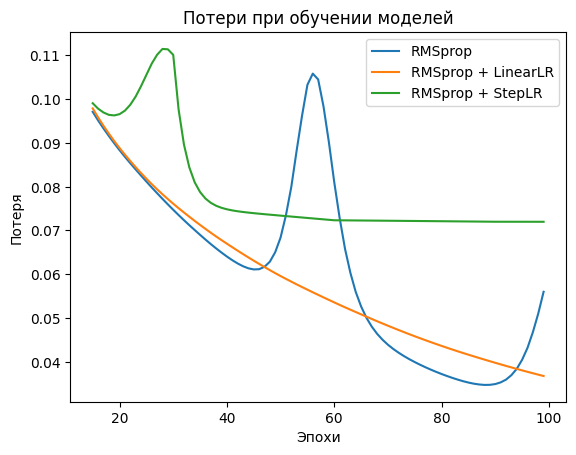

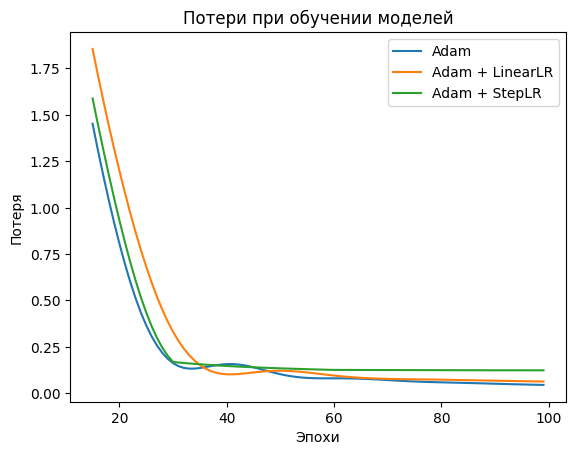

In [35]:
FROM_EPOCH = 15
for optimizer_label, optimizer_ctor in optimizers.items():
    losses = results[optimizer_label]
    epochs = range(FROM_EPOCH, len(losses))

    plt.plot(epochs, losses[FROM_EPOCH:], label=optimizer_label)

    for scheduler_label, scheduler_ctor in schedulers.items():
        label = f"{optimizer_label} + {scheduler_label}"
        losses, _ = results[label]
        plt.plot(epochs, losses[FROM_EPOCH:], label=label)

    plt.title("Потери при обучении моделей")
    plt.xlabel("Эпохи")
    plt.ylabel("Потеря")
    plt.legend()
    plt.show()

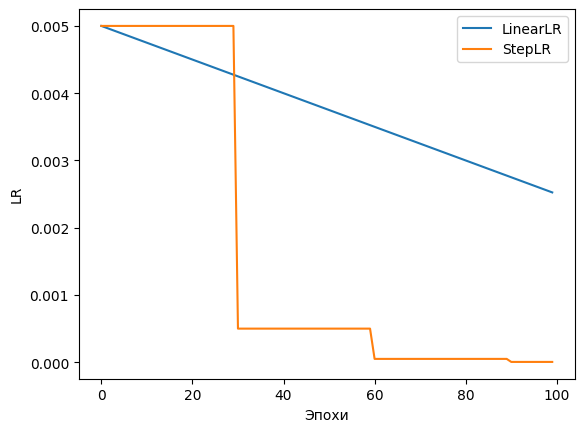

In [37]:
for scheduler_label, _ in schedulers.items():
    label = f"Adam + {scheduler_label}"
    _, lrs = results[label]
    plt.plot(lrs, label=scheduler_label)

plt.xlabel("Эпохи")
plt.ylabel("LR")
plt.legend()
plt.show()

## Выводы

1. Наилучшие результаты обучения были получены с использованием RMSprop с шедулером LinearLR.
2. Следующие по качеству обучения — Nesterov и Adam без шедулеров.
3. LinearLR делает кривую обучения более гладкой.
4. StepLR показал себя хуже всего, это может быть результатом неудачного выбора гиперпараметров.
5. Общим недостатком шедулеров является то, что они не учитывают особенности ландшафта и принцип, которым надо руководствоваться при выборе гиперпараметров, не очевидны.
   